In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dropout,Activation,Flatten,BatchNormalization,Dense
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,LearningRateScheduler
from keras.utils import to_categorical
from sklearn.utils import class_weight

C:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [30]:
import cv2

In [2]:
df = pd.read_csv(r'fer2013\fer2013.csv')
emotions_list = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


Length of DataFrame: 35887
Data Usage: {'Training': 28709, 'PublicTest': 3589, 'PrivateTest': 3589}
Type of Pixel values: object
Data Distribution: {3: 8989, 6: 6198, 4: 6077, 2: 5121, 0: 4953, 5: 4002, 1: 547}


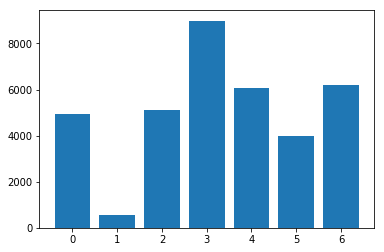

In [3]:
print("Length of DataFrame:",len(df))
usage = dict(df['Usage'].value_counts())
print("Data Usage:",usage)
print("Type of Pixel values:",df['pixels'].dtype)
data_distribution = dict(df['emotion'].value_counts())
print("Data Distribution:",data_distribution)
plt.bar(data_distribution.keys(),data_distribution.values());

In [4]:
X_train,X_valid,X_test,y_train,y_valid,y_test = [],[],[],[],[],[]
for image,emotion,usage in zip(df['pixels'].values,df['emotion'].values,df['Usage'].values):
    if usage=="Training":
        X_train.append(np.array(image.split(' '),'float32').reshape(48,48,1))
        y_train.append(to_categorical(emotion,num_classes=len(emotions_list)))
    elif usage=="PublicTest":
        X_valid.append(np.array(image.split(' '),'float32').reshape(48,48,1))
        y_valid.append(to_categorical(emotion,num_classes=len(emotions_list)))
    elif usage=="PrivateTest":
        X_test.append(np.array(image.split(' '),'float32').reshape(48,48,1))
        y_test.append(to_categorical(emotion,num_classes=len(emotions_list)))
X_train = np.array(X_train)
y_train = np.array(y_train)
X_valid = np.array(X_valid)
y_valid = np.array(y_valid)
X_test = np.array(X_test)
y_test = np.array(y_test)

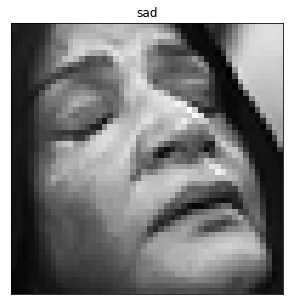

In [18]:
index = np.random.randint(0,len(X_train)-1)
plt.figure(figsize=(5,5))
plt.imshow(X_train[index].reshape(48,48),cmap='gray')
plt.title(emotions_list[y_train[index].argmax()])
plt.xticks([])
plt.yticks([]);

In [7]:
TRAIN_ITER = ImageDataGenerator(rescale=1/255,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                height_shift_range=0.1,
                                width_shift_range=0.1,
                                rotation_range=30).flow(X_train,y_train)
VALID_ITER = ImageDataGenerator(rescale=1/255).flow(X_valid,y_valid)
TEST_ITER = ImageDataGenerator(rescale=1/255).flow(X_test,y_test)

In [8]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(df['emotion']),
                                                 df['emotion'])

In [24]:
model = Sequential()
model.add(Conv2D(32,(3,3),padding='same',input_shape=(48,48,1),activation='relu'))
model.add(Conv2D(32,(3,3),padding='same',activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.4))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(4096,activation='relu'))
model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.9))
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(emotions_list),activation='softmax'))

model.compile(optimizer=Adam(0.0001),loss=categorical_crossentropy,metrics=['acc'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 48, 48, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 22, 22, 64)        18496     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 20, 20, 64)        36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 10, 10, 64)       

In [10]:
early_stopping = EarlyStopping(patience=10,restore_best_weights=True)

In [25]:
history = model.fit_generator(TRAIN_ITER,
                    steps_per_epoch=(TRAIN_ITER.n//TRAIN_ITER.batch_size)*1.5,
                    validation_data=VALID_ITER,
                    validation_steps=VALID_ITER.n//VALID_ITER.batch_size,
                    epochs = 100,
                    class_weight = class_weights,
                    callbacks=[early_stopping])

Epoch 1/100
1346/1345 [==============================] - 107s 80ms/step - loss: 1.8357 - acc: 0.2395 - val_loss: 1.8072 - val_acc: 0.2497
Epoch 2/100
1346/1345 [==============================] - 107s 80ms/step - loss: 1.8091 - acc: 0.2489 - val_loss: 1.7773 - val_acc: 0.2522
Epoch 3/100
1346/1345 [==============================] - 107s 80ms/step - loss: 1.7615 - acc: 0.2736 - val_loss: 1.6695 - val_acc: 0.3199
Epoch 4/100
1346/1345 [==============================] - 107s 80ms/step - loss: 1.6740 - acc: 0.3194 - val_loss: 1.5241 - val_acc: 0.3888
Epoch 5/100
1346/1345 [==============================] - 106s 79ms/step - loss: 1.5911 - acc: 0.3642 - val_loss: 1.4344 - val_acc: 0.4363
Epoch 6/100
1346/1345 [==============================] - 107s 79ms/step - loss: 1.5280 - acc: 0.4031 - val_loss: 1.3539 - val_acc: 0.4757
Epoch 7/100
1346/1345 [==============================] - 106s 79ms/step - loss: 1.4761 - acc: 0.4269 - val_loss: 1.3203 - val_acc: 0.4881
Epoch 8/100
1346/1345 [===========

Text(0.5,1,'Accuracy')

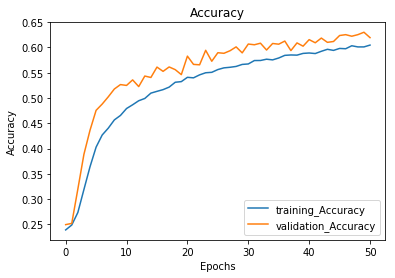

In [26]:
plt.plot(history.history['acc'],label='training_Accuracy')
plt.plot(history.history['val_acc'],label='validation_Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Accuracy")

Text(0.5,1,'Loss')

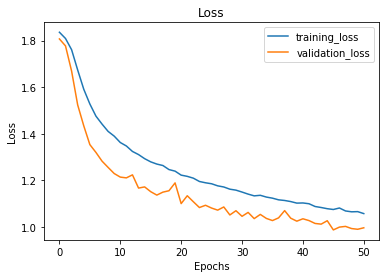

In [27]:
plt.plot(history.history['loss'],label='training_loss')
plt.plot(history.history['val_loss'],label='validation_loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Loss")

In [28]:
model.evaluate_generator(TEST_ITER)

[0.9570529879999546, 0.6425188074838687]

In [29]:
model.save('emotion_detection_Acc_64_onTest.h5')